# Smoke Test: Depthviz

#### Dr John Hughes

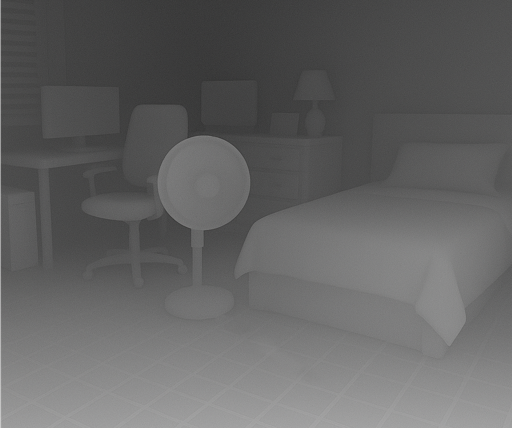

In [2]:
from PIL import Image
from IPython.display import display
depth_map = Image.open("../assets/DarkNav.png")
scale=0.5;
display(depth_map.resize((int(depth_map.width * scale), int(depth_map.height * scale))))

### Display colored depth map using OpenVision tools (cv2)

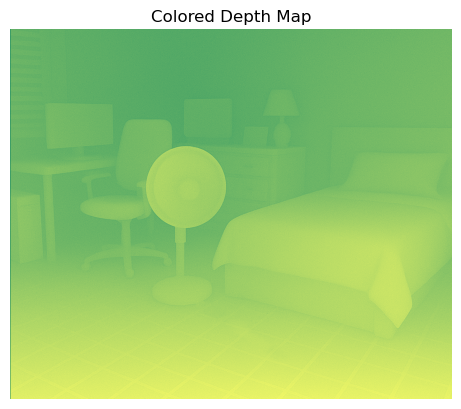

In [3]:
    import cv2                   # OpenVision
    import numpy as np
    import matplotlib.pyplot as plt

    depth_map = cv2.imread('../assets/DarkNav.png', cv2.IMREAD_GRAYSCALE)
    depth_norm = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX)
    depth_colored = cv2.applyColorMap(depth_norm, cv2.COLORMAP_SUMMER)

    # Display colored depth map
    plt.imshow(cv2.cvtColor(depth_colored, cv2.COLOR_BGR2RGB))
    plt.title('Colored Depth Map')
    plt.axis('off')
    plt.show()

#### Scale depth maps

THis impacts the number of points created in the point cloud

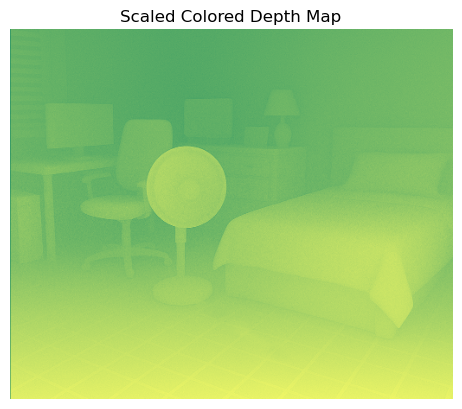

In [120]:
# Scale images
new_scale = 0.5
new_dimensions = (int(depth_colored.shape[1]*new_scale), int(depth_colored.shape[0]*new_scale))
depth_map_scaled = cv2.resize(depth_map, new_dimensions)
depth_colored_scaled = cv2.resize(depth_colored, new_dimensions)

# Display colored depth map
plt.imshow(cv2.cvtColor(depth_colored_scaled, cv2.COLOR_BGR2RGB))
plt.title('Scaled Colored Depth Map')
plt.axis('off')
plt.show()

## Create point cloud from depth maps

In [5]:
import open3d as o3d

# Use the scaled grayscale depth (8-bit) and a color image (for visualization)
# depth_map_scaled : uint8 grayscale (0..255)
# depth_colored_scaled : BGR uint8 for display only (convert to RGB for Open3D)

# 1) Normalize to [0,1] and use exponential to stretch depth
d = depth_map_scaled.astype(np.float32) / 255.0
d = d**0.67

# 2) If your image uses "bright = NEAR", invert it so big value = FAR
#    (comment this line out if your grayscale is already "bright = FAR")
d = 1.0 - d
 
# 3) Map to metric depth (meters). Pick a plausible range for your scene.
z_near, z_far = 0.2, 10.0  # meters *** tune as needed ***
z_m = z_near + d * (z_far - z_near)

# 4) Convert to the format Open3D expects: uint16 in millimeters if depth_scale=1000
depth_mm = (z_m * 1000.0).astype(np.uint16)

# 5) Build Open3D images
o3d_depth = o3d.geometry.Image(depth_mm)
o3d_color = o3d.geometry.Image(cv2.cvtColor(depth_colored_scaled, cv2.COLOR_BGR2RGB))

rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    o3d_color,
    o3d_depth,
    depth_scale=1000.0,     # 1000 mm == 1 m
    depth_trunc=z_far,      # clip anything beyond z_far
    convert_rgb_to_intensity=False
)

# 6) Intrinsics MUST match the scaled image size
height, width = depth_mm.shape
# If you don’t know fx, fy, assume ~60° horiz FOV: fx = width/(2*tan(FOV/2))
FOV_deg = 60.0
fx = fy = width / (2.0 * np.tan(np.deg2rad(FOV_deg) / 2.0))
cx = width / 2.0 - 0.5
cy = height / 2.0 - 0.5
intrinsic = o3d.camera.PinholeCameraIntrinsic(width, height, fx, fy, cx, cy)

# 7) Create the point cloud
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, intrinsic)
print("Calculated point cloud:", len(pcd.points), "points.")

# Remove noise from the point cloud 
pcd, ind = pcd.remove_statistical_outlier(nb_neighbors=30, std_ratio=2.0)
print("Cleaned point cloud:", len(pcd.points), "points.")
print("Point cloud:", np.asarray(pcd.points).shape)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Calculated point cloud: 219136 points.
Cleaned point cloud: 211468 points.
Point cloud: (211468, 3)


### Display point cloud in Open 3D window

In [6]:
# Flip to OpenGL-like coords for nicer viewing (Open3D doc pattern) and scale depth if needed
pcd.transform([[1, 0, 0, 0],
               [0,-1, 0, 0],
               [0, 0,-1.15, 0],
               [0, 0, 0, 1]])

colors = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]], dtype=np.float64) # RGB colors
pcd.colors = o3d.utility.Vector3dVector(colors)
o3d.visualization.draw_geometries([pcd])

print("Point cloud:", np.asarray(pcd.points).shape)

Point cloud: (211468, 3)


## VLM Goal Parser Smoke Test

If you have Ollama and LLaMA 3.2 Vision installed this test will examine the image to determine where the chair is located and return a hint that can be used to guide a robot. Run it multiple times to get different hints such as:
```
{'target': 'chair', 'hint': 'on the left side of the room'}
{'target': 'chair', 'hint': 'in the corner of the room'}
{'target': 'chair', 'hint': 'to the left of the bed'}
{'target': 'chair', 'hint': 'in the background'}
{'target': 'chair', 'hint': 'next to the desk'}
{'target': 'chair', 'hint': 'on the left'}
```

In [119]:
# Optional VLM goal parser (tries Ollama if available; otherwise uses a stub)
import json, shutil, os, base64, ollama
from pathlib import Path

# Convert image to base64 to avoid issues with file paths inside Ollama
IMG = "../assets/DarkNav.png"  
b64 = base64.b64encode(Path(IMG).read_bytes()).decode("utf-8")

QUERY = "Identify the 'chair' in this scene. Return JSON: {\"target\":\"chair\",\"hint\":\"where/what\"}."

def vlm_goal_parse(img_path, prompt):
    if shutil.which("ollama"):
        try:
            messages = [
                {"role":"system","content":"Return JSON only."},
                {"role":"user","content": prompt, "images":[img_path]},
            ]
            out = []
            for chunk in ollama.chat(model="llama3.2-vision", messages=messages, stream=True):
                txt = chunk.get("message",{}).get("content","")
                if txt: out.append(txt)
            raw = "".join(out).strip()
            # naive JSON scrub
            start, end = raw.find("{"), raw.rfind("}")
            if start != -1 and end != -1:
                return json.loads(raw[start:end+1])
        except Exception as e:
            print("[vlm stub] Ollama error:", e)
    # Fallback stub
    return {"target":"chair", "hint":"left-of-center near desk"}

print(vlm_goal_parse(IMG, QUERY))

{'target': 'chair', 'hint': 'to the left of the bed'}
